In [1]:
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#TODO: Fix random seeds for reproducibility

In [2]:
class OscillatoryGridCell1D(nn.Module):
    def __init__(self, *args, randomize=True, dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        self.shift = self._init_param(0, lambda x: nn.init.uniform_(x, 0, 1) if randomize else x)
        self.scaling = self._init_param(1, lambda x: nn.init.trunc_normal_(x, 1, 1.0, 0.1, 10) if randomize else x)

    def forward(self, position):
        """Encode a point on a cartesian 1D axis to a grid cell activation."""
        # We scale only the coordinates to keep the shift in the [0, 1] range
        position = self.scaling * position - self.shift
        return (torch.cos(2 * torch.pi * position) + 1) / 2
    
    def _init_param(self, default_value, init_function):
        param = torch.tensor(default_value, dtype=self.dtype, device=self.device)
        init_function(param)
        param = nn.Parameter(param, requires_grad=True)
        return param

In [97]:
class GridCellArray1D(nn.Module):
    def __init__(self, n_neurons, *args, dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        assert n_neurons > 0, "Number of neurons must be positive."
        self.neurons = nn.ModuleList([OscillatoryGridCell1D(dtype=dtype, device=device) for _ in range(n_neurons)])

    def forward(self, X):
        """Encode a point on a cartesian 2D plane to a vector of grid cell neuron activations."""
        return torch.stack([cell(X) for cell in self.neurons], dim=-1).squeeze(dim=0)

In [98]:
grid_cell = OscillatoryGridCell1D(randomize=False, dtype=torch.float32, device=device)

In [99]:
grid_cell(0)

tensor(1., grad_fn=<DivBackward0>)

In [100]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

grid_cell(positions)

tensor([1.0000, 0.5000, 0.0000, 0.5000, 1.0000, 0.5000, 0.0000, 0.5000, 1.0000],
       grad_fn=<DivBackward0>)

In [101]:
N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

In [102]:
randomized_grid_cell = OscillatoryGridCell1D(randomize=True, dtype=torch.float32, device=device)

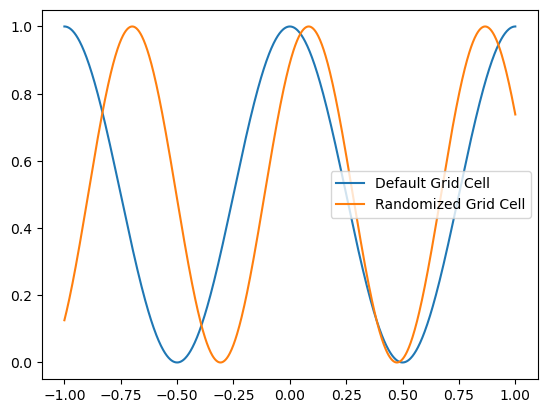

In [103]:
plt.plot(positions, grid_cell(positions).detach().numpy(), label="Default Grid Cell")
plt.plot(positions, randomized_grid_cell(positions).detach().numpy(), label="Randomized Grid Cell")
plt.legend()

In [104]:
grid_cell_array = GridCellArray1D(5, dtype=torch.float32, device=device)

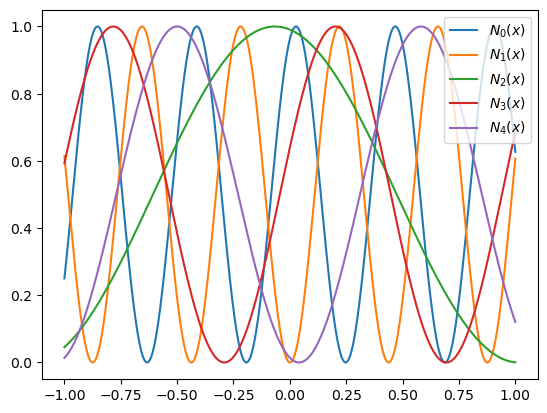

In [105]:
for i, neuron in enumerate(grid_cell_array.neurons):
    plt.plot(positions, neuron(positions).detach().numpy(), label=f"$N_{i}(x)$")

plt.legend()

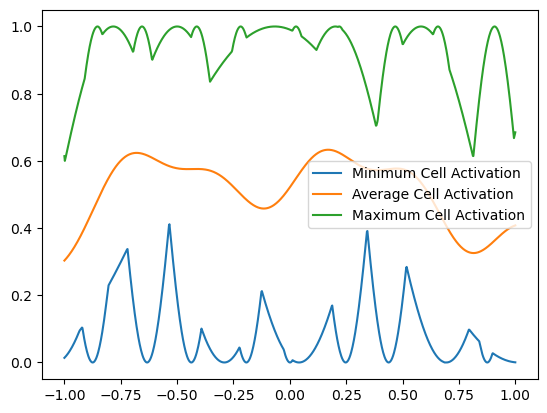

In [106]:
plt.plot(positions, grid_cell_array(positions).min(axis=-1).values.detach().numpy(), label="Minimum Cell Activation")
plt.plot(positions, grid_cell_array(positions).mean(axis=-1).detach().numpy(), label="Average Cell Activation")
plt.plot(positions, grid_cell_array(positions).max(axis=-1).values.detach().numpy(), label="Maximum Cell Activation")

plt.legend()

In [107]:
class LinearDecoder1D(nn.Module):
    def __init__(self, grid_cell_array, *args, dtype=torch.float32, device="cpu", weighted=True, **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        self.n_neurons = len(grid_cell_array.neurons)
        
        self.grid_cell_array = grid_cell_array
        # We don't need need bias because we will be inferring the predicted position from the maximum activation value
        log_weights = torch.ones(self.n_neurons, dtype=dtype, device=device)
        if weighted:
            nn.init.normal_(log_weights, 0, 1)
        self.log_weights = nn.Parameter(log_weights, requires_grad=weighted)
        self.weight_softmax = nn.Softmax(dim=-1)
        self.position_softmax = nn.Softmax(dim=-1)
    
    def forward(self, true_activations, position_estimates):
        """Decode the neuron representation"""
        assert (true_activations.shape[-1] == self.n_neurons), "The number of neurons in the grid cell array must match the number of neurons used the true activations."
        assert len(true_activations.shape) <= 2, "The true activations must be a tensor of shape (n_true_positions, n_neurons)."
        if len(true_activations.shape) == 1:
            true_activations = true_activations.reshape(1, self.n_neurons)

        # 1. Compute the activation for possible X estimations
        estimated_activations = self.grid_cell_array(position_estimates)

        # 2. Multiply it by the activations for the true positions (it will discriminate against the other positions)
        # TODO: Optimize this step using better vectorization technique
        if len(estimated_activations.shape) == 1:
            estimated_activations = estimated_activations.reshape(1, -1)
        discriminated_activations = (estimated_activations.expand(true_activations.shape[0], -1, -1).transpose(0, 1) * true_activations).transpose(0, 1)
        # 3. Compute the weighted sum using the decoder weights (the decoder will consider some neurons more "valuable" than others)
        decoded_activations = discriminated_activations @ self.weights()
        # Apply softmax to get the position probability distribution estimate
        position_probabilities = self.position_softmax(decoded_activations.reshape(true_activations.shape[0], -1))
        # 4. Find the position expectations by computing the weighted sum of the position estimations' probabilities
        position_expectations = position_probabilities @ position_estimates
        most_probable_positions = position_estimates[position_probabilities.argmax(dim=-1)]
        return position_probabilities, position_expectations, most_probable_positions
    
    def weights(self):
        # Note that we are using the softmax of the weights to enforce the weights to be positive and to sum up to 1
        return self.weight_softmax(self.log_weights)

In [108]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=False)
decoder.weights()

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

In [109]:
true_x = torch.tensor([0.5], dtype=torch.float32, device=device)
true_activations = grid_cell_array(true_x)
true_activations

tensor([0.9476, 0.1848, 0.4623, 0.3376, 0.9449], grad_fn=<SqueezeBackward1>)

In [110]:
positions = torch.tensor([0.5], dtype=torch.float32, device=device)

position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)

print((true_activations.reshape(1, -1) ** 2).mean(dim=-1))

position_probabilities, position_expectations, most_probable_positions

tensor([0.4305], grad_fn=<MeanBackward1>)


(tensor([[1.]], grad_fn=<SoftmaxBackward0>),
 tensor([0.5000], grad_fn=<MvBackward0>),
 tensor([0.5000]))

In [111]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=True)
decoder.weights()

tensor([0.3486, 0.1849, 0.1897, 0.0634, 0.2135], grad_fn=<SoftmaxBackward0>)

In [112]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

decoder(true_activations, positions)

(tensor([[0.0898, 0.1140, 0.1299, 0.1050, 0.1210, 0.0960, 0.1386, 0.1021, 0.1037]],
        grad_fn=<SoftmaxBackward0>),
 tensor([0.0071], grad_fn=<MvBackward0>),
 tensor([0.5000]))

In [113]:
true_x = torch.tensor([0, 0.5, 1, 10], dtype=torch.float32, device=device)
true_activations = grid_cell_array(true_x)
true_activations

tensor([[9.6245e-01, 1.5795e-05, 9.9065e-01, 6.3953e-01, 1.4015e-02],
        [9.4758e-01, 1.8476e-01, 4.6228e-01, 3.3756e-01, 9.4494e-01],
        [6.2696e-01, 6.0637e-01, 4.5395e-04, 6.8498e-01, 1.2085e-01],
        [2.0627e-01, 1.9955e-01, 2.1841e-01, 9.7357e-01, 3.7508e-01]],
       grad_fn=<SqueezeBackward1>)

In [114]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

decoder(true_activations, positions)

(tensor([[0.0940, 0.1109, 0.1203, 0.1053, 0.1428, 0.1013, 0.1275, 0.0917, 0.1062],
         [0.0898, 0.1140, 0.1299, 0.1050, 0.1210, 0.0960, 0.1386, 0.1021, 0.1037],
         [0.1056, 0.1163, 0.1120, 0.1063, 0.1155, 0.1065, 0.1188, 0.1037, 0.1154],
         [0.1042, 0.1151, 0.1157, 0.1095, 0.1118, 0.1122, 0.1163, 0.1069, 0.1083]],
        grad_fn=<SoftmaxBackward0>),
 tensor([ 0.0004,  0.0071,  0.0037, -0.0010], grad_fn=<MvBackward0>),
 tensor([0.0000, 0.5000, 0.5000, 0.5000]))

In [115]:
grid_cell_array = GridCellArray1D(5, dtype=torch.float32, device=device)
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=True)

N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

true_positions = torch.tensor([0, 0.5, 1, -1, -0.5], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_positions)
position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)
print(position_probabilities.shape)
print(position_expectations)
print(most_probable_positions)

torch.Size([5, 1001])
tensor([-0.0155,  0.0155,  0.0096, -0.0354, -0.0420], grad_fn=<MvBackward0>)
tensor([-0.1100,  0.8620,  0.8960, -0.6880, -0.5440])


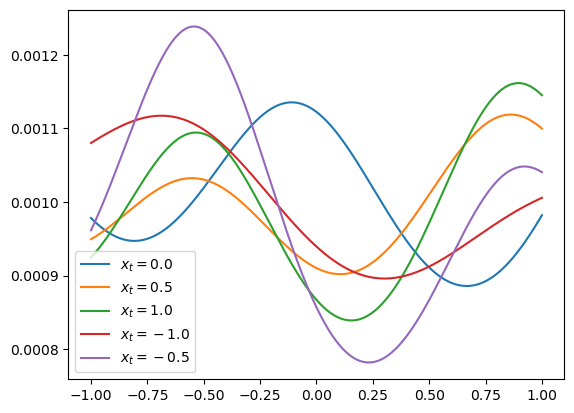

In [116]:
for i, true_position in enumerate(true_positions):
    plt.plot(positions, position_probabilities[i].detach().numpy(), label=f"$x_t={true_position}$")

plt.legend()

In [165]:
def train(*, n_neurons=5, weighted_decoder=True, n_positions=1000, batch_size=100, n_epochs=100, learning_rate=0.01, verbose=True, dtype=torch.float32, device="cpu"):
    # Define the desired domain
    
    positions = torch.empty(n_positions, dtype=dtype, device=device)
    torch.nn.init.normal_(positions, 0, 1)

    # Define the grid cell array and the decoder
    grid_cell_array = GridCellArray1D(n_neurons, dtype=dtype, device=device)
    decoder = LinearDecoder1D(grid_cell_array, dtype=dtype, device=device, weighted=weighted_decoder)

    # Define the optimizer
    optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    loss = 0

    eye = torch.eye(batch_size, requires_grad=False, dtype=dtype, device=device)

    for epoch in range(n_epochs):
        # Generate a batch of random positions
        # We assume that the points are distributed normally across zero with the sigma of 1 for both x and y

        for i in range(0, n_positions, batch_size):
            optimizer.zero_grad()
            # TODO: Use DataSet and DataLoader

            batch_positions = positions[i:i + batch_size]
            true_activations = grid_cell_array(batch_positions)
            position_probabilities, position_expectations, _ = decoder(true_activations, batch_positions)

            loss = 0

            ## TODO: Use MSE loss from torch.nn
            loss += ((position_expectations - positions) ** 2).mean()
            
            # Increase probability for true positions: 
            #loss -= torch.log(position_probabilities*eye).sum()

            loss.backward()
            optimizer.step()

        if verbose:
            true_activations = grid_cell_array(positions)
            _, position_expectations, _ = decoder(true_activations, positions)
            print(true_activations)
            print(position_expectations)
            loss = ((position_expectations - positions) ** 2).mean()
            print("Epoch {:3d} - Loss: {:.6f}".format(epoch + 1, loss.item()))
        

    return grid_cell_array, decoder

In [161]:
dtype=torch.float32
n_positions = 10
n_neurons = 5
positions = torch.empty(n_positions, dtype=dtype, device=device)
torch.nn.init.normal_(positions, 0, 1);
positions

tensor([-1.9342, -1.6692, -0.1525, -0.0927, -0.0967, -0.4381,  1.8148,  1.3409,
        -0.4693,  0.0091])

In [162]:
grid_cell_array = GridCellArray1D(n_neurons, dtype=dtype, device=device)
decoder = LinearDecoder1D(grid_cell_array, dtype=dtype, device=device, weighted=True)

In [163]:
grid_cell_array(positions)

tensor([[5.0836e-01, 2.6798e-01, 2.2352e-02, 9.7343e-01, 1.3366e-01],
        [9.7124e-01, 8.8925e-01, 9.6279e-01, 6.1455e-01, 9.8731e-01],
        [5.9386e-01, 8.8388e-02, 9.9989e-01, 7.3631e-02, 6.0179e-02],
        [7.8916e-01, 3.2843e-01, 8.6590e-01, 5.8406e-01, 2.2837e-03],
        [7.7722e-01, 3.0897e-01, 8.8227e-01, 5.4411e-01, 7.7200e-04],
        [1.9783e-02, 8.4779e-01, 2.5065e-02, 2.9709e-01, 9.9227e-01],
        [9.9657e-01, 7.2267e-01, 7.0937e-01, 6.9729e-01, 2.2110e-03],
        [4.1761e-03, 9.7921e-01, 9.0394e-01, 3.0264e-01, 5.6181e-01],
        [6.2386e-02, 9.4336e-01, 1.1676e-01, 6.9504e-02, 9.4262e-01],
        [9.8728e-01, 8.2188e-01, 2.9613e-01, 9.0595e-01, 2.7403e-01]],
       grad_fn=<SqueezeBackward1>)

In [164]:
grid_cell_array, decoder = train(n_epochs=1, n_positions=100, batch_size=100, learning_rate=0.01, dtype=torch.float32, device=device)

tensor([[4.4941e-01, 1.5247e-04, 2.2523e-01, 8.2535e-01, 2.2872e-01],
        [8.8884e-01, 3.6975e-01, 1.3690e-01, 3.4002e-01, 2.9753e-03],
        [7.2757e-01, 3.1901e-01, 1.2825e-01, 6.5822e-02, 6.3726e-01],
        [7.6061e-02, 6.8893e-01, 2.9783e-01, 9.9958e-01, 6.5610e-01],
        [7.7054e-01, 4.2045e-01, 4.3228e-01, 4.3560e-02, 5.9002e-01],
        [3.9156e-01, 1.7735e-02, 7.6155e-01, 3.2096e-01, 9.0796e-01],
        [7.7246e-01, 4.2525e-01, 4.4836e-01, 4.2639e-02, 5.8782e-01],
        [2.3573e-01, 2.2374e-01, 1.8679e-02, 4.8469e-01, 9.7976e-01],
        [2.2279e-01, 2.5441e-01, 6.3788e-01, 9.6437e-01, 4.5126e-01],
        [1.2925e-04, 9.9934e-01, 2.3416e-01, 9.0749e-01, 8.8744e-01],
        [7.7028e-01, 4.1657e-01, 9.0358e-01, 5.2069e-01, 2.8521e-02],
        [3.9578e-03, 9.8267e-01, 7.3622e-01, 9.4564e-01, 8.3755e-01],
        [9.5556e-01, 9.3448e-01, 4.9518e-01, 2.4768e-01, 1.2393e-02],
        [8.9236e-01, 7.5513e-01, 6.7967e-03, 3.5840e-01, 5.9217e-05],
        [3.3965e-02,

torch.Size([5, 1001])
tensor([-0.0897, -0.0517, -0.0177, -0.0836, -0.1013], grad_fn=<MvBackward0>)
tensor([-0.7260, -0.1780, -0.8000, -0.7200, -0.5240])


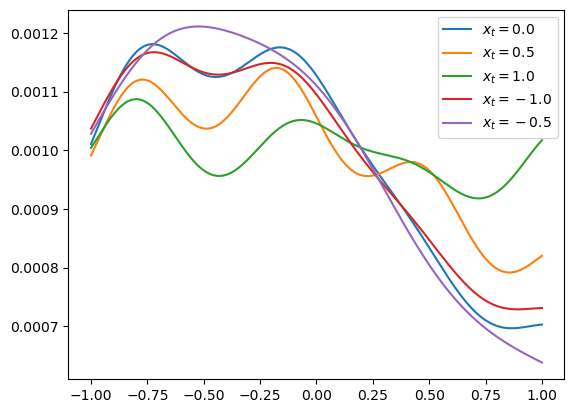

In [129]:
N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

true_positions = torch.tensor([0, 0.5, 1, -1, -0.5], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_positions)
position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)
print(position_probabilities.shape)
print(position_expectations)
print(most_probable_positions)

for i, true_position in enumerate(true_positions):
    plt.plot(positions, position_probabilities[i].detach().numpy(), label=f"$x_t={true_position}$")

plt.legend()